In [1]:
import os
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from scipy.stats import spearmanr, pearsonr
import seaborn as sns
import ipywidgets as widgets
import plotly.express as px
# from tqdm.notebook import tqdm
from itables import show
# from statsmodels.formula.api import mixedlm
# from statsmodels.stats.multitest import multipletests
# from statsmodels.tools.sm_exceptions import ConvergenceWarning
from IPython.display import clear_output

## Initialization

### Read metadata, read metabolite table, read family level microbiome feature table

In [2]:
meta = pd.read_csv("input_folder/metadata48.tsv", sep="\t", index_col=0)
crit1 = meta["Group"] != "S"
crit2 = meta["Hour"] != 0

meta = meta.loc[crit1 & crit2, :]
meta["Hour"] = meta["Hour"].astype(int)
meta["GH"] = meta["Group"] + meta["Hour"].astype(str)

meta.index = [re.sub("H$", "", i) for i in meta.index]
show(meta)

In [3]:
def read_met_table(met_table_path):
    met_table = pd.read_csv(met_table_path, sep="\t", index_col=0)
    met_table.set_index("Compound", inplace=True)
    met_table = met_table.loc[:, [c for c in met_table.columns if "-" in c]]
    met_table = met_table.T
    met_table.index = [re.sub("H$", "", i) for i in met_table.index]
    return met_table

met_table_path = "input_folder/MT.tsv"

met_table = read_met_table(met_table_path)
show(met_table)

In [4]:
def read_taxa_table(level, meta=None, n_taxa=12):
    df = pd.read_csv(f"input_folder/feature_tables/feature_table_l{level}.tsv", skiprows=1, sep="\t", index_col=0)
    
    upper_bound = df.sum().to_list()[0]
    # df = df.loc[[idx for idx in df.index.tolist() if "p__" in idx], :]
    df.index = [re.sub(".*p__", "p__", i) for i in df.index.tolist()]
    if level == 2:
        df.index = [re.sub(".*p__", "", i) for i in df.index.tolist()]
    else:
        df.index = [re.sub(";c__.*;", ";", i) for i in df.index.tolist()]
    
    df.columns = [re.sub("H$", "", c) for c in df.columns]
    
    if meta is not None:
        sample_list = meta.index.tolist()
        sample_list = [s for s in sample_list if s[1] != "4"]
        # print(sample_list)
        # print(df.columns.tolist())
        df = df.loc[:, sample_list]
    
    # df = df.loc[:, sample_list]
    df = df.loc[df.sum(axis="columns").sort_values(ascending=False).index.tolist()[:n_taxa], :]
    
    df = df/upper_bound*100
    return df

# l2 = read_taxa_table(2, meta)
# l5 = read_taxa_table(5, meta)
# l5.head()

ft5 = read_taxa_table(5, meta=meta)
upper_bound = ft5.sum().to_list()[0]

ft5.index = [re.sub(".*p__", "p__", i) for i in ft5.index.tolist()]

ft5 = ft5.loc[ft5.sum(axis="columns").sort_values(ascending=False).index.tolist(), :]
ft5 = ft5/upper_bound*100
ft5.columns = [re.sub("H$", "", i) for i in ft5.columns.tolist()]
show(ft5)

In [5]:
ft5 = pd.read_csv("input_folder/feature_tables/feature_table_l5.tsv", skiprows=1, sep="\t", index_col=0)
upper_bound = ft5.sum().to_list()[0]

ft5.index = [re.sub(".*p__", "p__", i) for i in ft5.index.tolist()]

ft5 = ft5.loc[ft5.sum(axis="columns").sort_values(ascending=False).index.tolist(), :]
ft5 = ft5/upper_bound*100
ft5.columns = [re.sub("H$", "", i) for i in ft5.columns.tolist()]
show(ft5)

# Plot taxa composition

In [6]:
taxa_level_descs = {
    2: "Phyla",
    3: "Class",
    4: "Order",
    5: "Family",
    6: "Genera",
}

batches = ["C1", "C2", "C3", "M1", "M2", "M3"]

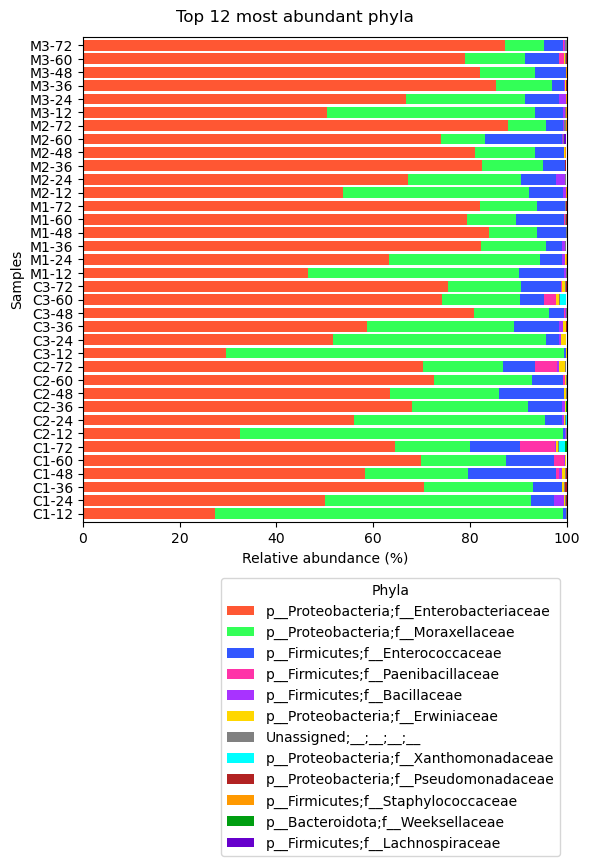

In [7]:
df = read_taxa_table(5, meta) 
colors_list = ["#FF5733", "#33FF57", "#3357FF", "#FF33A8", "#A833FF", "#FFD700", "#808080", "#00FFFF", "#B22222", "#FF9900", "#009E11", "#6600CC"]

fig, ax = plt.subplots(dpi=100, figsize=(6, 9))

# df.loc[:, reversed(sample_list)]\
df.T.plot(kind="barh", stacked=True, width=0.8, ax=ax, color=colors_list)

plt.legend(bbox_to_anchor=(1, -0.1), title="Phyla")
ax.set_xlim(0, 100)
ax.set_xlabel("Relative abundance (%)")
ax.set_ylabel("Samples")

n_taxa = 12
fig.suptitle(f"Top {n_taxa} most abundant phyla")
plt.tight_layout()
plt.show()

# fig.savefig("top_phyla.png")

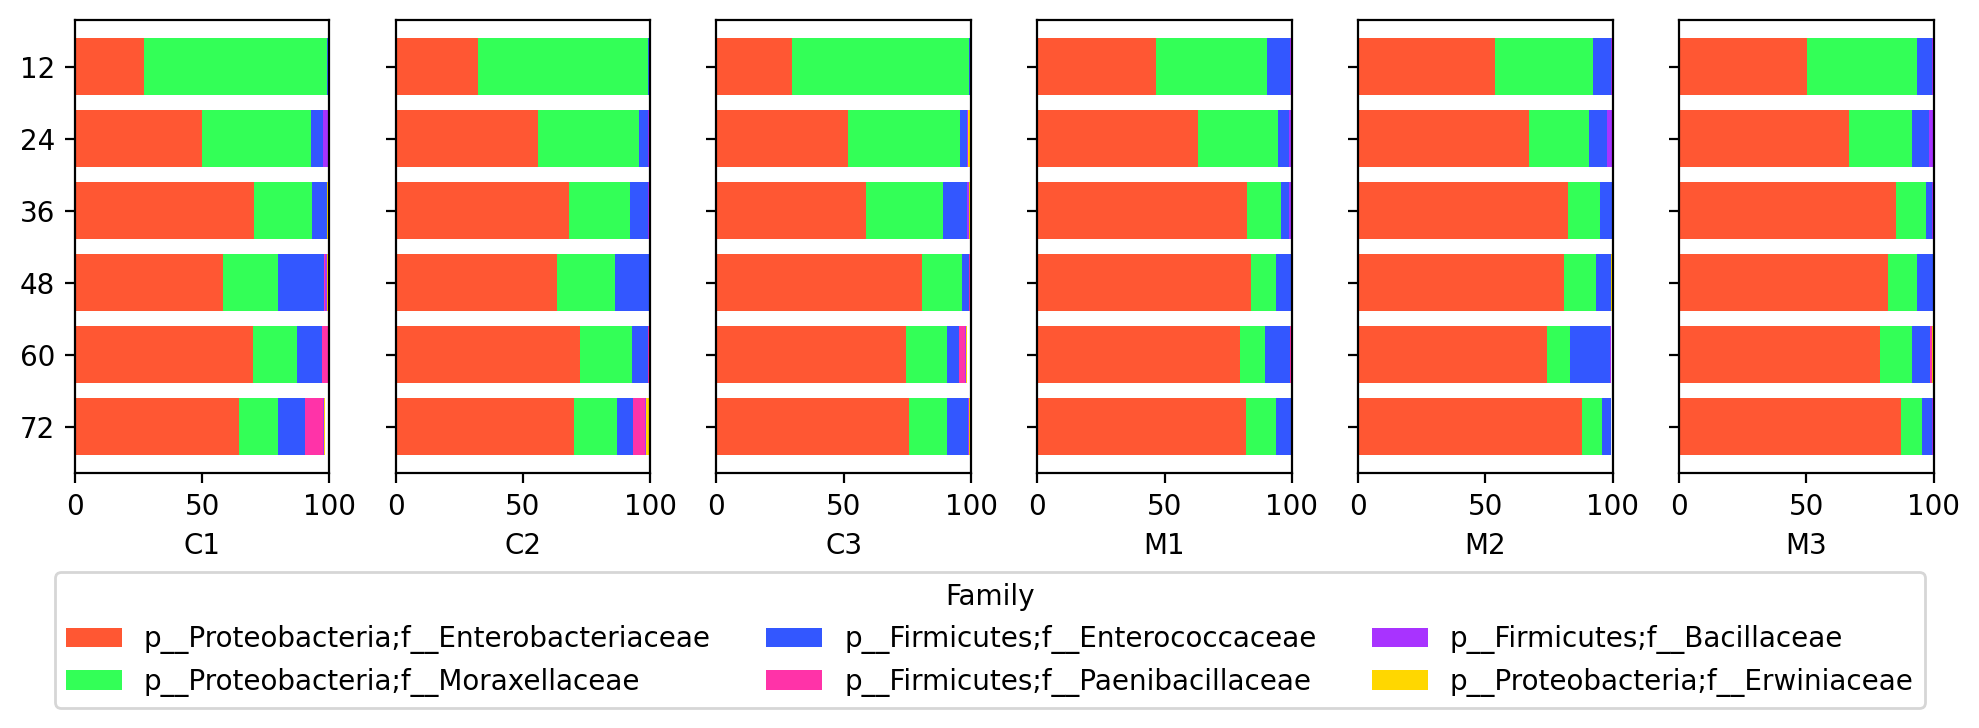

In [8]:
taxa_level = 5
taxa_level_desc = taxa_level_descs[taxa_level]
df = read_taxa_table(taxa_level, meta, n_taxa=6)


fig, axs = plt.subplots(ncols=6, nrows=1, dpi=200, figsize=(10, 3))
axs = axs.ravel()


ax_idx = 0
for batch in batches:
    ax = axs[ax_idx]
    crit1 = meta["Replicate"] == batch
    
    sample_list = meta.loc[crit1 , :].index.tolist()
    
    sample_list = reversed(sample_list)
    df.loc[:, sample_list]\
        .T.plot(kind="barh", stacked=True, width=0.8, ax=ax, color=colors_list, legend=False)

    ax.set_xlim(0, 100)
    ax.set_xlabel(batch)

    if ax_idx == 0:
        newyticklabels = []
        for i in ax.get_yticklabels():
            j = i
            oldtext = i.get_text()
            newtext = re.sub(".*-", "", oldtext)
            j.set_text(newtext)
            newyticklabels.append(j)
        ax.set_yticklabels(newyticklabels)
        handles, labels = ax.get_legend_handles_labels()
    else:
        ax.set_yticklabels([])
    
    
    ax_idx = ax_idx + 1

fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.22),
           ncol=3, title=taxa_level_desc)

plt.tight_layout()
plt.show()

#### It is quite interesting how we have Paenibacillae later in fermentation only in conventional group

# Plot beta diversity

In [9]:
beta_divs = [i for i in os.listdir("input_folder/coords/") if i.endswith("coords.tsv")]
beta_divs = [re.sub("_coor.*", "", i) for i in beta_divs]
beta_divs

['jaccard', 'bray_curtis', 'weighted_unifrac', 'unweighted_unifrac']

In [10]:
def read_raw_ord_table(beta):
    with open(f"input_folder/coords/{beta}_coords.tsv") as f:
        s = f.readlines()
    
    for idx, l in enumerate(s):
        if l.startswith("Site"):
            n1 = idx + 1
            break
    
    for idx, l in enumerate(s):
        if l.startswith("Biplot"):
            n2 = idx -1
            break
    
    s = s[n1:n2]
    s = [l.strip() for l in s]
    s = [l.split("\t") for l in s]
    
    s = pd.DataFrame(s)
    s.set_index(0, inplace=True)
    s = s.loc[:, :3]

    
    s.columns = [f"PCoA{c}" for c in s.columns.tolist()]

    for i in range(1,3):
        s[f"PCoA{i}"] = pd.to_numeric(s[f"PCoA{i}"])
    
    s.index = [re.sub("H$", "", i) for i in s.index]
    l2 = read_taxa_table(2, meta=meta)
    l5 = read_taxa_table(5, meta=meta)
    # print(l2.index.tolist())
    # print(s.index.tolist())
    s = meta.merge(s, left_index=True, right_index=True)
    s = s.merge(l2.T, left_index=True, right_index=True)
    s = s.merge(l5.T, left_index=True, right_index=True)
    return s

beta = beta_divs[0]
t = read_raw_ord_table(beta)
show(t)

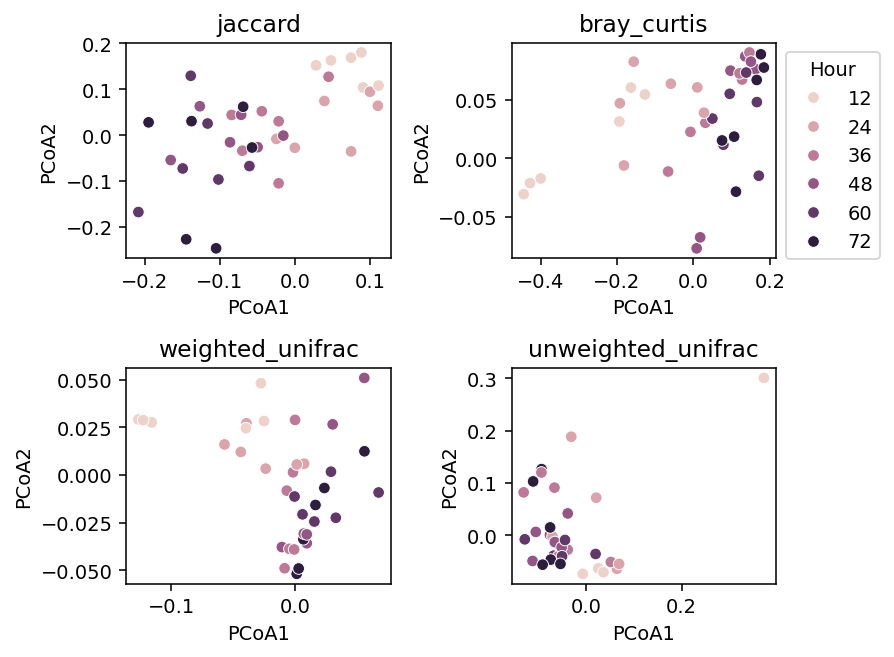

In [11]:
hue="Hour"
fig, axs = plt.subplots(ncols=2, nrows=2, dpi = 140)
axs = axs.ravel()

for idx, beta in enumerate(beta_divs):
    ax = axs[idx]

    if idx != 1:
        sns.scatterplot(read_raw_ord_table(beta), x="PCoA1", y="PCoA2", hue=hue, legend=False, ax=ax)
    else:
        sns.scatterplot(read_raw_ord_table(beta), x="PCoA1", y="PCoA2", hue=hue, ax=ax)
        ax.legend(bbox_to_anchor=(1,1), title=hue)
    ax.set_title(beta)

    
plt.tight_layout()
plt.show()

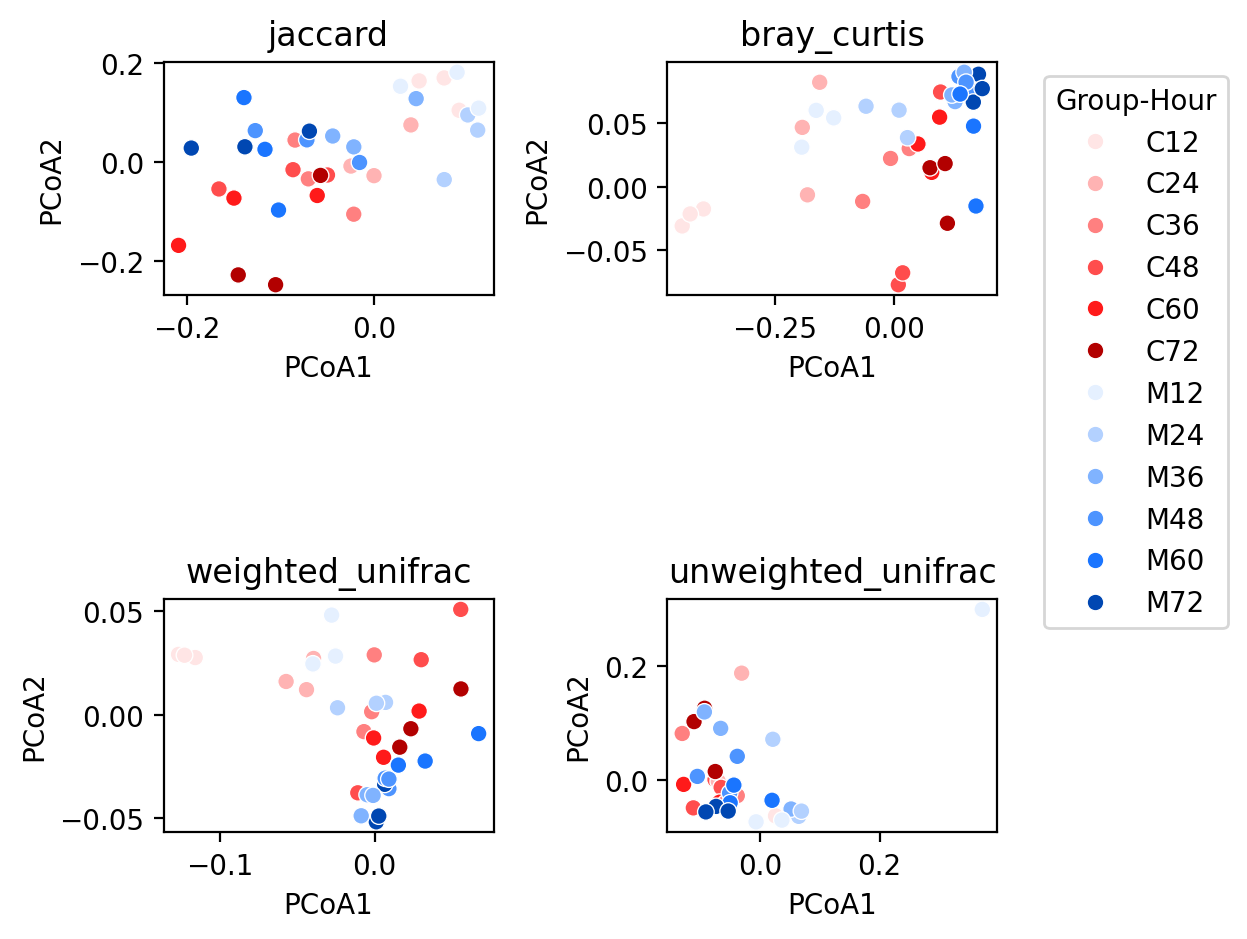

In [12]:
palette_gh = {   # Sample_Source
    'C12': "#FFE5E5", 'C24': "#FFB3B3", 'C36': "#FF8080",
    'C48': "#FF4D4D", 'C60': "#FF1A1A", 'C72': "#B20000",
    'M12': "#E5F0FF", 'M24': "#B3D1FF", 'M36': "#80B3FF",
    'M48': "#4D94FF", 'M60': "#1A75FF", 'M72': "#0047B2"
}

hue = "GH"
title = "Group-Hour"
fig, axs = plt.subplots(ncols=2, nrows=2, dpi = 200)
axs = axs.ravel()

for idx, beta in enumerate(beta_divs):
    ax = axs[idx]

    if idx != 1:
        sns.scatterplot(read_raw_ord_table(beta), x="PCoA1", y="PCoA2", hue=hue,
                        palette=palette_gh, legend=False, ax=ax)
    else:
        sns.scatterplot(read_raw_ord_table(beta), x="PCoA1", y="PCoA2", hue=hue,
                        palette=palette_gh, ax=ax)
        ax.legend(bbox_to_anchor=(1.1,1), title=title)
        # ax.legend.title = "Group"
    ax.set_title(beta)

    
plt.tight_layout()
plt.show()

# Correlate microbiome-metabolome

### Mixed linear effects model
- Account for random effects within group_hour
- Assess fixed effects of hour, group, group_hour and their interaction on metabolite concentration

### Atempting mixed linear effect model, modeling how Concentration changes with Group, Hour, and their interaction, while accounting for random effects within Group-Hour samples 

In [13]:
adjusted_df = pd.read_csv("input_folder/lme_metabolite_corr.tsv", sep="\t", index_col=0)
show(adjusted_df)

In [14]:
# define metabolite
# metabolite = "Lysinium"

def plot_metabolite_bar(change):
    # get replicate_ids
    metabolite = change["new"]
    replicates = meta.loc[:, "Replicate"].unique().tolist()
    
    metabolite_max = met_table.loc[:, metabolite].max()
    # print(metabolite_max)
    
    fig, axs = plt.subplots(ncols=len(replicates), figsize=(12,4))

    for idx, replicate in enumerate(replicates):
        ax = axs[idx]
        sub_meta = meta.loc[meta["Replicate"] == replicate, :]
        sub_meta = sub_meta.sort_values("Hour")
        sub_met_table = met_table.loc[sub_meta.index.tolist(), [metabolite]]
        

        sns.barplot(data=sub_met_table, y=sub_met_table.index, x=metabolite, ax=ax)
        ax.set_xlabel(replicate)
        
        if metabolite_max > 0:
            ax.set_xlim(0, metabolite_max)
        
        if idx == 0:
            ax.set_ylabel(metabolite)

            newticklabels = [re.sub("C.-", "", yticklabel.get_text()) for yticklabel in ax.get_yticklabels()]
            newticklabels = [re.sub("$", "H", yticklabel) for yticklabel in newticklabels]
            ax.set_yticks(ax.get_yticks())
            ax.set_yticklabels(newticklabels)
        else:
            ax.set_ylabel(None)
            ax.set_yticklabels([])
            
    fig.suptitle(metabolite)
    
    plt.tight_layout()
    plt.show()

metabolites = met_table.columns.tolist()
metabolite_dropdown = widgets.Dropdown(options=sorted(metabolites), description="Metabolites:")
# metabolite_dropdown.observe(plot_metabolite_bar, names="value")

output = widgets.Output()
dashboard = widgets.VBox([metabolite_dropdown, output])

def update_dashboard(change):
    with output:
        clear_output(wait=True)
        plot_metabolite_bar(change)

metabolite_dropdown.observe(update_dashboard, names='value')

display(dashboard)
update_dashboard({'new': metabolite_dropdown.value})

### Correlate metabolome with Paenibacillaceae

In [15]:
ft5 = read_taxa_table(5, meta=meta)
# Prepare your taxa vector
paeni = ft5.loc['p__Firmicutes;f__Paenibacillaceae', :].T
paeni = paeni.rename("Paenibacillaceae")

## Significant metabolite, sorted by p_Pearson_adj

In [16]:
sig_corrs = pd.read_csv("input_folder/paeni_corr.tsv", sep="\t", index_col=0)
show(sig_corrs.sort_values("p_Pearson_adj", ascending=False))

### Scatterplot of metabolite against Paenibacillae

In [21]:
# Paeni series
paeni.name = "Paenibacillaceae"

# Dropdowns
metabolite_dropdown = widgets.Dropdown(
    description='Metabolite:',
    layout=widgets.Layout(width='50%')
)

metadata_dropdown = widgets.Dropdown(
    options=["Group", "Hour", "GH"],
    description='Metadata:',
    layout=widgets.Layout(width='50%')
)

# Sorting controls
sort_by_radio = widgets.RadioButtons(
    options=['Metabolite', 'r_Pearson', 'p_Pearson', 'r_Spearman', 'p_Spearman', 'p_Pearson_adj', 'p_Spearman_adj'],
    value='p_Pearson_adj',
    description='Sort metabolites by:'
)

order_toggle = widgets.ToggleButtons(
    options=[('Descending', False), ('Ascending', True)],
    value=False,
    description='Order metabolites:'
)

# Output widget
out = widgets.Output()

# Function to update the dropdown based on sort controls
def update_metabolite_dropdown(*args):
    sort_col = sort_by_radio.value
    ascending = order_toggle.value

    sorted_mets = sig_corrs.sort_values(sort_col, ascending=ascending)["Metabolite"].tolist()
    metabolite_dropdown.options = sorted_mets

    # Reset value to the first option to trigger update
    metabolite_dropdown.value = sorted_mets[0] if sorted_mets else None

# Attach to both sorting widgets
sort_by_radio.observe(update_metabolite_dropdown, names='value')
order_toggle.observe(update_metabolite_dropdown, names='value')

# Plotting function
def plot_corr(change=None):
    metabolite_name = metabolite_dropdown.value
    metadata_name = metadata_dropdown.value

    if metabolite_name is None or metadata_name is None:
        return

    smet = met_table[metabolite_name]
    corr_df = pd.merge(paeni, smet, left_index=True, right_index=True)
    corr_df.columns = ["Paenibacillaceae", "Metabolite"]
    corr_df = pd.merge(corr_df, meta, left_index=True, right_index=True)

    # Plot in Output widget
    with out:
        clear_output(wait=True)
        g = sns.lmplot(
            data=corr_df,
            x="Paenibacillaceae",
            y="Metabolite",
            hue=metadata_name,
            scatter_kws={"s": 40, "alpha": 0.8},
            height=4,
            aspect=1.5,
            ci=0,
            facet_kws={"legend_out": True}
        )
        g.fig.subplots_adjust(right=0.85)

        # Get p_Pearson_adj for title
        p_val = sig_corrs.set_index("Metabolite").loc[metabolite_name, "p_Pearson_adj"]
        g.fig.suptitle(f"{metabolite_name}, p_Pearson_adj={p_val:.2e}")

        plt.close(g.fig)
        display(g.fig)

# Attach observers to dropdowns
metabolite_dropdown.observe(plot_corr, names='value')
metadata_dropdown.observe(plot_corr, names='value')

# Layout widgets
control_row = widgets.HBox([metabolite_dropdown, sort_by_radio, order_toggle])
control_row = widgets.VBox([control_row, metadata_dropdown])
display(widgets.VBox([control_row, out]))

# Initial dropdown population and first plot
update_metabolite_dropdown()